In [1]:
import csv
import os

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyhrv
from opensignalsreader import OpenSignalsReader
import matplotlib
from tsfel import feature_extraction

from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## This notebook take previously extracted features and perform relugar analysis

In [2]:
feature_main_train = pd.read_csv('X_train_extracted.csv').iloc[:,1:]
feature_hrv_train = pd.read_csv('X_train_hrv.csv').iloc[:,1:]
feature_wavelet_train = pd.read_csv('X_train_extracted_wavelet.csv')

feature_main_test = pd.read_csv('X_test_extracted.csv').iloc[:,1:]
feature_hrv_test = pd.read_csv('X_test_hrv.csv').iloc[:,1:]
feature_wavelet_test = pd.read_csv('X_test_extracted_wavelet.csv')

y_train = pd.read_csv('y_train.csv').iloc[:,1:]

In [3]:
all_features_train = pd.concat([feature_hrv_train,feature_main_train,feature_wavelet_train], axis=1)
all_features_train

min_hr      max_hr     std_hr     mean_hr   median_hr  signal_mean  \
0      70.680871  146.448980  10.232507   74.614771   72.192771     9.252964   
1      69.678350   85.586597   3.975789   76.344440   75.393426     3.099435   
2      62.172890   70.603353   2.222078   66.716786   66.598143    16.272974   
3     118.349540  170.026161  11.681454  150.677985  152.690974   -25.972687   
4      83.424856  108.436358   5.943025   99.399605  100.384891   -21.468062   
...          ...         ...        ...         ...         ...          ...   
5112   68.965517  139.401010  21.610936   87.673461   77.400843   -17.040447   
5113   66.537127   70.868347   0.773221   69.511665   69.500832     5.511492   
5114   61.595023   89.404463   8.764188   76.964032   75.527404    -0.380841   
5115   68.183767   74.324551   1.396115   70.808787   70.716359     7.740578   
5116   89.864249  111.804118   5.642619  101.762454  102.723641   -12.096895   

      signal_median   signal_sd  signal_max  signal_min  ...         84  \
0             -22.0  109.080337       738.0      -236.0  ... -74.349891   
1              -5.0  122.440336       746.0      -399.0  ... -35.048968   
2               2.0  200.377573      1588.0      -976.0  ...  37.616316   
3             -39.0  212.318462       864.0      -874.0  ...   8.559223   
4             -21.0  156.702879       679.0      -737.0  ...  -3.888924   
...             ...         ...         ...         ...  ...        ...   
5112          -15.0  350.137102      1368.0     -1922.0  ... -64.721638   
5113            5.0   78.615996       515.0      -188.0  ...  36.237878   
5114          -28.0  185.522124       976.0      -801.0  ... -67.298086   
5115           -6.0   70.454310       397.0      -243.0  ... -43.380758   
5116           -7.0  127.238668       503.0      -731.0  ...   4.805098   

             85          86          87          88          89          90  \
0    -78.672208  -75.189425  -68.082189  -59.725063  -51.366183  -43.640834   
1    -26.567513  -19.286465  -13.122427   -7.855282   -4.023556   -1.433072   
2     32.536490   23.072608   12.008615    1.910680   -7.404887  -16.511748   
3     68.073099  140.919073  214.608737  252.627165  214.174341  109.790794   
4     -2.517301   -2.185354   -2.931865   -4.328650   -5.935876   -8.058705   
...         ...         ...         ...         ...         ...         ...   
5112 -21.707782   16.337232   27.564005   12.183821   -3.625841    6.729030   
5113  31.175525   24.648108   17.372508    9.917913    3.781885   -0.165958   
5114 -56.192773  -45.350307  -34.639553  -24.403215  -15.952806  -10.103572   
5115 -48.005432  -47.399986  -44.033647  -39.123104  -33.329488  -27.563101   
5116   4.888037    2.915531   -0.789978   -3.120436   -2.033093   -0.302978   

             91         92          93  
0    -34.928311 -26.626816  -19.910683  
1      0.185563   1.129459    0.466735  
2    -24.846311 -30.788248  -34.124698  
3     -9.310240 -91.189810 -140.572172  
4    -10.137914 -11.371025  -10.922754  
...         ...        ...         ...  
5112  17.275212   5.312162  -33.049426  
5113  -2.307634  -3.196255   -3.468430  
5114  -6.024608  -3.112312   -1.470891  
5115 -21.428708 -15.951019  -11.533621  
5116   0.388864   0.959699    2.844391  

[5117 rows x 132 columns]

In [5]:
std = StandardScaler()
original_train_standarized = std.fit_transform(all_features_train)

In [4]:
all_features_test = pd.concat([feature_hrv_test,feature_main_test,feature_wavelet_test], axis=1)
all_features_test

min_hr      max_hr     std_hr     mean_hr   median_hr  signal_mean  \
0     62.510604   74.796861   4.366141   70.277400   72.122188    32.694585   
1     51.894703   60.555006   2.220559   56.139195   56.312074    25.958193   
2     52.500825  116.251198  18.071460   74.766662   68.944280     6.875376   
3     60.675231   63.684188   0.855625   62.224823   62.148522     4.515663   
4     57.598099   64.240052   1.899901   60.723841   60.525255    28.770084   
...         ...         ...        ...         ...         ...          ...   
3406  56.505058  150.839768  23.646815   95.751592   85.226926    -8.868418   
3407  56.493202  115.947911  16.417606   66.229101   60.338738     0.420236   
3408  71.695350   93.967539   5.184102   79.625615   78.518972    13.040609   
3409  80.718571   83.851337   0.812008   82.087076   81.943850    12.833253   
3410  79.278192  133.563796  13.202397  105.692358  104.560141    17.986085   

      signal_median   signal_sd  signal_max  signal_min  ...         84  \
0               8.0  295.136865      1713.0      -774.0  ... -50.000834   
1              10.0  153.411453      1093.0      -170.0  ...  48.277174   
2              -6.0  248.369246      1356.0     -1133.0  ... -28.376523   
3              -8.0  115.784816       697.0      -484.0  ... -12.877318   
4               5.0  164.083926      1184.0      -212.0  ...  13.823396   
...             ...         ...         ...         ...  ...        ...   
3406          -13.0  148.315337       566.0     -3554.0  ...   3.999504   
3407          -22.0  172.227500      1814.0      -824.0  ... -70.549053   
3408          -16.0  133.411280       677.0      -590.0  ... -16.210682   
3409           -6.0   93.842708       653.0      -161.0  ... -22.254713   
3410          -10.0  244.987862      1709.0     -1217.0  ...   2.323555   

             85         86         87         88         89         90  \
0    -48.352729 -41.116533 -31.369107 -23.601416 -17.700247 -11.629999   
1     58.693879  64.771103  64.826316  58.813924  46.448098  29.438884   
2    -39.801021 -56.308224 -70.187804 -74.400540 -64.716219 -40.245151   
3    -29.335235 -39.892699 -44.990288 -45.479563 -43.260648 -40.134061   
4      8.366280   1.574142  -5.631423 -10.510756 -12.425262 -12.375448   
...         ...        ...        ...        ...        ...        ...   
3406   0.888883  -0.270380   0.399568 -11.839106 -38.006462 -46.708102   
3407 -77.304932 -80.256728 -75.854838 -65.577970 -57.348978 -52.141932   
3408  -9.219633  -4.520144  -1.833824   0.155059   2.391204   4.592822   
3409 -24.082728 -24.252709 -23.368830 -21.270155 -18.585964 -16.428467   
3410   4.985755   3.854780   0.195361  -3.860009  -7.411310  -8.498977   

             91         92         93  
0     -7.151217  -6.433426  -7.045046  
1     10.936813  -3.314670 -12.593792  
2    -12.654854   3.628246   7.457928  
3    -35.244548 -29.793048 -24.711657  
4    -10.757284  -8.501521  -7.106327  
...         ...        ...        ...  
3406 -23.227583  10.497349  20.998755  
3407 -45.953036 -40.077141 -36.728866  
3408   5.940115   6.313794   6.235601  
3409 -14.395338 -12.352773 -10.446189  
3410  -5.763918  -0.342441   0.793354  

[3411 rows x 132 columns]

In [8]:
std = StandardScaler()
original_test_standarized = std.fit_transform(all_features_test)

In [5]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model
from pyod.models.iforest import IForest

In [19]:
# feature selection

combined_x = pd.concat([all_features_train,all_features_test], axis = 0)
combined_x

min_hr      max_hr     std_hr     mean_hr   median_hr  signal_mean  \
0      70.680871  146.448980  10.232507   74.614771   72.192771     9.252964   
1      69.678350   85.586597   3.975789   76.344440   75.393426     3.099435   
2      62.172890   70.603353   2.222078   66.716786   66.598143    16.272974   
3     118.349540  170.026161  11.681454  150.677985  152.690974   -25.972687   
4      83.424856  108.436358   5.943025   99.399605  100.384891   -21.468062   
...          ...         ...        ...         ...         ...          ...   
3406   56.505058  150.839768  23.646815   95.751592   85.226926    -8.868418   
3407   56.493202  115.947911  16.417606   66.229101   60.338738     0.420236   
3408   71.695350   93.967539   5.184102   79.625615   78.518972    13.040609   
3409   80.718571   83.851337   0.812008   82.087076   81.943850    12.833253   
3410   79.278192  133.563796  13.202397  105.692358  104.560141    17.986085   

      signal_median   signal_sd  signal_max  signal_min  ...         84  \
0             -22.0  109.080337       738.0      -236.0  ... -74.349891   
1              -5.0  122.440336       746.0      -399.0  ... -35.048968   
2               2.0  200.377573      1588.0      -976.0  ...  37.616316   
3             -39.0  212.318462       864.0      -874.0  ...   8.559223   
4             -21.0  156.702879       679.0      -737.0  ...  -3.888924   
...             ...         ...         ...         ...  ...        ...   
3406          -13.0  148.315337       566.0     -3554.0  ...   3.999504   
3407          -22.0  172.227500      1814.0      -824.0  ... -70.549053   
3408          -16.0  133.411280       677.0      -590.0  ... -16.210682   
3409           -6.0   93.842708       653.0      -161.0  ... -22.254713   
3410          -10.0  244.987862      1709.0     -1217.0  ...   2.323555   

             85          86          87          88          89          90  \
0    -78.672208  -75.189425  -68.082189  -59.725063  -51.366183  -43.640834   
1    -26.567513  -19.286465  -13.122427   -7.855282   -4.023556   -1.433072   
2     32.536490   23.072608   12.008615    1.910680   -7.404887  -16.511748   
3     68.073099  140.919073  214.608737  252.627165  214.174341  109.790794   
4     -2.517301   -2.185354   -2.931865   -4.328650   -5.935876   -8.058705   
...         ...         ...         ...         ...         ...         ...   
3406   0.888883   -0.270380    0.399568  -11.839106  -38.006462  -46.708102   
3407 -77.304932  -80.256728  -75.854838  -65.577970  -57.348978  -52.141932   
3408  -9.219633   -4.520144   -1.833824    0.155059    2.391204    4.592822   
3409 -24.082728  -24.252709  -23.368830  -21.270155  -18.585964  -16.428467   
3410   4.985755    3.854780    0.195361   -3.860009   -7.411310   -8.498977   

             91         92          93  
0    -34.928311 -26.626816  -19.910683  
1      0.185563   1.129459    0.466735  
2    -24.846311 -30.788248  -34.124698  
3     -9.310240 -91.189810 -140.572172  
4    -10.137914 -11.371025  -10.922754  
...         ...        ...         ...  
3406 -23.227583  10.497349   20.998755  
3407 -45.953036 -40.077141  -36.728866  
3408   5.940115   6.313794    6.235601  
3409 -14.395338 -12.352773  -10.446189  
3410  -5.763918  -0.342441    0.793354  

[8528 rows x 132 columns]

In [20]:
np_combined_x = combined_x.to_numpy()
np_combined_x.shape

(8528, 132)

In [198]:
np_combined_x += 1e-7
x_var = np.var(np_combined_x/np.mean(np_combined_x,axis = 0), axis = 0)
x_index = x_var > 0
np_combined_x -= 1e-7
np_combined_preselected = np_combined_x[:,x_index]

In [199]:
np_combined_preselected.shape

(8528, 132)

In [200]:
preselected_standarized = StandardScaler().fit_transform(np_combined_preselected)

In [6]:
y_dropped = y_train.to_numpy()

In [248]:
y_dropped.shape

(5117, 1)

In [203]:
x_train_preselected = preselected_standarized[:len(all_features_train)]

In [204]:
x_test_preselected = preselected_standarized[len(all_features_train):]

In [205]:
class_zero = x_train_preselected[y_train['y'] == 0]
class_one = x_train_preselected[y_train['y'] == 1]
class_two = x_train_preselected[y_train['y'] == 2]
class_three = x_train_preselected[y_train['y'] == 3]

In [206]:
print(class_zero.shape)
print(class_one.shape)
print(class_two.shape)
print(class_three.shape)

(3030, 132)
(443, 132)
(1474, 132)
(170, 132)


In [207]:
#do not do feature selection
all_features_train

signal_mean  signal_median   signal_sd  signal_max  signal_min  \
0        9.252964          -22.0  109.080337       738.0      -236.0   
1        3.099435           -5.0  122.440336       746.0      -399.0   
2       16.272974            2.0  200.377573      1588.0      -976.0   
3      -25.972687          -39.0  212.318462       864.0      -874.0   
4      -21.468062          -21.0  156.702879       679.0      -737.0   
...           ...            ...         ...         ...         ...   
5112   -17.040447          -15.0  350.137102      1368.0     -1922.0   
5113     5.511492            5.0   78.615996       515.0      -188.0   
5114    -0.380841          -28.0  185.522124       976.0      -801.0   
5115     7.740578           -6.0   70.454310       397.0      -243.0   
5116   -12.096895           -7.0  127.238668       503.0      -731.0   

      sd_beat_mean  sd_beat_median  sd_beat_sd  sd_beat_max  sd_beat_min  ...  \
0        21.177366       18.301699   10.740427    66.877682    10.911437  ...   
1        20.502922       18.827493    6.240304    44.997328    13.176285  ...   
2        13.761332        9.683161   11.609992    78.700793     4.752194  ...   
3        62.791023       31.327965   81.638220   402.409376    18.323697  ...   
4        23.462408       19.200563   15.391773    89.128902    10.574557  ...   
...            ...             ...         ...          ...          ...  ...   
5112    136.951350      131.444310   36.052856   250.974658    59.805857  ...   
5113     11.730159       10.151575    5.217123    33.875287     6.581330  ...   
5114     21.511856       17.995853   11.884665    81.833907     8.858916  ...   
5115      9.461335        7.737418    4.894605    32.020797     4.882776  ...   
5116     29.296366       25.999582   11.194242    82.322222    17.305301  ...   

             84         85          86          87          88          89  \
0    -74.349891 -78.672208  -75.189425  -68.082189  -59.725063  -51.366183   
1    -35.048968 -26.567513  -19.286465  -13.122427   -7.855282   -4.023556   
2     37.616316  32.536490   23.072608   12.008615    1.910680   -7.404887   
3      8.559223  68.073099  140.919073  214.608737  252.627165  214.174341   
4     -3.888924  -2.517301   -2.185354   -2.931865   -4.328650   -5.935876   
...         ...        ...         ...         ...         ...         ...   
5112 -64.721638 -21.707782   16.337232   27.564005   12.183821   -3.625841   
5113  36.237878  31.175525   24.648108   17.372508    9.917913    3.781885   
5114 -67.298086 -56.192773  -45.350307  -34.639553  -24.403215  -15.952806   
5115 -43.380758 -48.005432  -47.399986  -44.033647  -39.123104  -33.329488   
5116   4.805098   4.888037    2.915531   -0.789978   -3.120436   -2.033093   

              90         91         92          93  
0     -43.640834 -34.928311 -26.626816  -19.910683  
1      -1.433072   0.185563   1.129459    0.466735  
2     -16.511748 -24.846311 -30.788248  -34.124698  
3     109.790794  -9.310240 -91.189810 -140.572172  
4      -8.058705 -10.137914 -11.371025  -10.922754  
...          ...        ...        ...         ...  
5112    6.729030  17.275212   5.312162  -33.049426  
5113   -0.165958  -2.307634  -3.196255   -3.468430  
5114  -10.103572  -6.024608  -3.112312   -1.470891  
5115  -27.563101 -21.428708 -15.951019  -11.533621  
5116   -0.302978   0.388864   0.959699    2.844391  

[5117 rows x 132 columns]

In [208]:
# remove outliers for four classes respectively
classifier = IForest(contamination=0.04, random_state=42)
classifier.fit(class_zero)
outliers_detect = classifier.predict(class_zero)
id_outlier_zero = [i for i in range(0, 3030) if outliers_detect[i] == 1]
print(len(id_outlier_zero))
class_zero_clean = np.delete(class_zero, id_outlier_zero, axis=0)
y_train_clean = np.delete(y_dropped, id_outlier_zero, axis=0)
print(y_train_clean.shape)

122
(4995, 1)


In [209]:
y_class_zero = np.full((3030 - 122, 1), 0)


In [210]:
y_class_zero.shape

(2908, 1)

In [211]:
classifier = IForest(contamination=0.04, random_state=42)
classifier.fit(class_one)
outliers_detect = classifier.predict(class_one)
id_outlier_one = [i for i in range(0, 443) if outliers_detect[i] == 1]
print(len(id_outlier_one))
class_one_clean = np.delete(class_one, id_outlier_one, axis=0)
y_train_clean = np.delete(y_train_clean, id_outlier_one, axis=0)
print(y_train_clean.shape)

18
(4977, 1)


In [212]:
y_class_one = np.full((443 - 18, 1), 1)

In [213]:
classifier = IForest(contamination=0.04, random_state=42)
classifier.fit(class_two)
outliers_detect = classifier.predict(class_two)
id_outlier_two = [i for i in range(0, 1474) if outliers_detect[i] == 1]
print(len(id_outlier_two))
class_two_clean = np.delete(class_two, id_outlier_two, axis=0)
y_train_clean = np.delete(y_train_clean, id_outlier_two, axis=0)
print(y_train_clean.shape)

59
(4918, 1)


In [214]:
y_class_two = np.full((1474 - 59, 1), 2)

In [215]:
classifier = IForest(contamination=0.04, random_state=42)
classifier.fit(class_three)
outliers_detect = classifier.predict(class_three)
id_outlier_three = [i for i in range(0, 170) if outliers_detect[i] == 1]
print(len(id_outlier_three))
class_three_clean = np.delete(class_three, id_outlier_three, axis=0)
y_train_clean = np.delete(y_train_clean, id_outlier_three, axis=0)
print(y_train_clean.shape)

7
(4911, 1)


In [216]:
y_class_three = np.full((170 - 7, 1), 3)

In [217]:
y_recombined = np.append(y_class_zero,y_class_one)


In [218]:
y_recombined = np.append(y_recombined,y_class_two)

In [219]:
y_recombined = np.append(y_recombined,y_class_three)

In [220]:
y_recombined = y_recombined.reshape(-1,1)

In [221]:
y_recombined.shape

(4911, 1)

In [222]:
class_zero_clean_pd = pd.DataFrame(class_zero_clean)
class_one_clean_pd = pd.DataFrame(class_one_clean)
class_two_clean_pd = pd.DataFrame(class_two_clean)
class_three_clean_pd = pd.DataFrame(class_three_clean)

In [223]:
recombined_x_clean_pd = pd.concat([class_zero_clean_pd,class_one_clean_pd,class_two_clean_pd,class_three_clean_pd])

In [224]:
recombined_x_clean = recombined_x_clean_pd.to_numpy()

In [225]:
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.02,max_depth=5, random_state=82)

In [229]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

C:\Users\liule\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


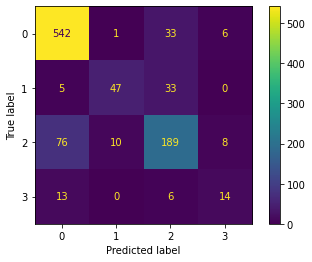

score:  0.8056968463886063


C:\Users\liule\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


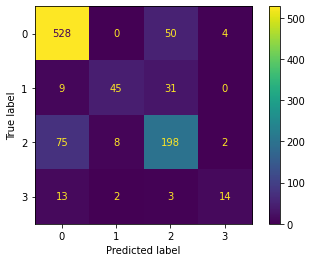

score:  0.7993890020366599


C:\Users\liule\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


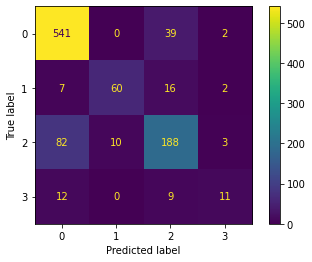

score:  0.814663951120163


C:\Users\liule\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


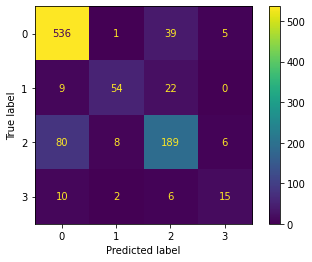

score:  0.8085539714867617


C:\Users\liule\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


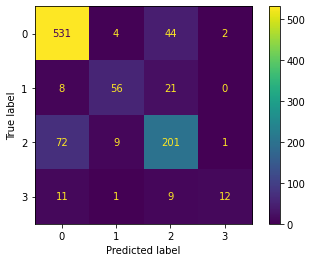

score:  0.814663951120163


[0.8056968463886063,
 0.7993890020366599,
 0.814663951120163,
 0.8085539714867617,
 0.814663951120163]

In [232]:
scores = []
kf = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in kf.split(recombined_x_clean,y=y_recombined):
    x_train = recombined_x_clean[train_idx]
    y_train = y_recombined[train_idx]
    x_test = recombined_x_clean[test_idx]
    y_test = y_recombined[test_idx]
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    s = f1_score(y_test, y_pred, average='micro')
    plot_confusion_matrix(clf,x_test,y_test)
    plt.show()
    print('score: ', s)
    scores.append(s)

scores

In [233]:
print(np.mean(scores))

0.8085935444304708


In [238]:
clf.fit(recombined_x_clean, y_recombined)

C:\Users\liule\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingClassifier(learning_rate=0.02, max_depth=5, n_estimators=300,
                           random_state=82)

In [239]:
y_pred = clf.predict(x_test_preselected)

In [7]:
import xgboost as xgb
from sklearn import naive_bayes
from sklearn import gaussian_process
from imblearn import ensemble
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [8]:
from imblearn.under_sampling import TomekLinks

In [9]:
gnb = naive_bayes.ComplementNB()
kernel = 8*gaussian_process.kernels.Matern(nu=1.5)
gpc = gaussian_process.GaussianProcessClassifier(kernel = kernel,optimizer='fmin_l_bfgs_b',random_state=666)

In [10]:
base_classifier = xgb.XGBClassifier(learning_rate=0.3,n_estimators=300,max_depth=4,min_child_weight=0,gamma=0.6,
                                            subsample=0.7,colsample_bytree=0.7,nthread=-1,scale_pos_weight=1,seed=1,reg_alpha=0.00006,random_state=1)
xgb_classfier = xgb.XGBClassifier(max_depth = 5, n_estimators = 114)

In [11]:
imbalance_classifier = ensemble.EasyEnsembleClassifier(base_estimator= xgb_classfier, random_state=42, n_estimators=300)

In [12]:
# stacking

gb_classifier = GradientBoostingClassifier(n_estimators=300, learning_rate=0.02,max_depth=5, random_state=82)
svm = SVC()
xgb_classfier = xgb.XGBClassifier(max_depth = 5, n_estimators = 114)
imbalance_classifier = ensemble.EasyEnsembleClassifier(base_estimator= base_classifier, random_state=42, n_estimators=300)
gpc = gaussian_process.GaussianProcessClassifier(kernel = kernel,optimizer='fmin_l_bfgs_b',random_state=666)

In [14]:
model_names = []
models = []

xgb_classfier = xgb.XGBClassifier(max_depth = 5, n_estimators = 114)
model_names.append("xgb")
models.append(xgb_classfier)

lgb_classifier = lgb.LGBMClassifier()
model_names.append('lgb')
models.append(lgb_classifier)

gb_classifier = GradientBoostingClassifier(n_estimators=300, learning_rate=0.02,max_depth=5, random_state=82)
model_names.append('gb')
models.append(gb_classifier)

base_classifier = xgb.XGBClassifier(learning_rate=0.3,n_estimators=300,max_depth=4,min_child_weight=0,gamma=0.6,
                                            subsample=0.7,colsample_bytree=0.7,nthread=-1,scale_pos_weight=1,seed=1,reg_alpha=0.00006,random_state=1)
imbalance_classifier = ensemble.EasyEnsembleClassifier(base_estimator= base_classifier, random_state=42, n_estimators=300)
model_names.append("imblance")
models.append(imbalance_classifier)

gpc = gaussian_process.GaussianProcessClassifier(kernel = kernel,optimizer='fmin_l_bfgs_b',random_state=666)
model_names.append('gaussian')
models.append(gpc)

svm = SVC()
model_names.append('svm')
models.append(svm)

knnc = KNeighborsClassifier(n_neighbors=5)
model_names.append('knn')
models.append(knnc)


logistic = LogisticRegressionCV()
model_names.append('logistic')
models.append(logistic)

ldm = LinearDiscriminantAnalysis()
model_names.append('ldm')
models.append(ldm)



In [15]:
from sklearn.ensemble import StackingClassifier

In [16]:
est = list(zip(model_names,models))
stacked = StackingClassifier(estimators=est)

In [17]:
all_features_train_np = all_features_train.to_numpy()

In [52]:
#try kpca
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA

np_x_standarized = StandardScaler().fit_transform(np_combined_x)

In [71]:
kpca = PCA(n_components=40)
X_transformed = kpca.fit_transform(np_combined_x)

In [72]:
X_transformed.shape

(8528, 40)

In [73]:
X_transformed_train = X_transformed[:len(all_features_train)]
X_transformed_train.shape

(5117, 40)

In [74]:
X_transformed_test= X_transformed[len(all_features_train):]
X_transformed_test.shape

(3411, 40)

[18:41:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


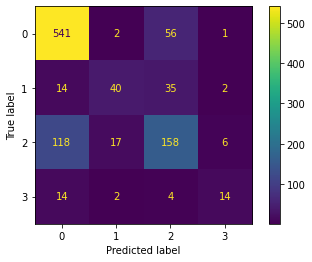

score:  0.7353515625
[18:41:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


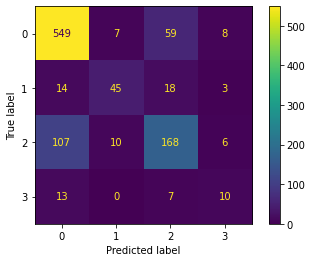

score:  0.75390625
[18:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


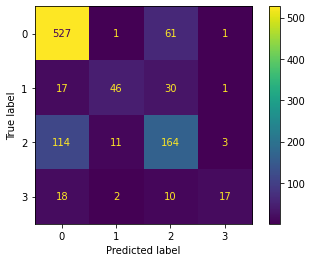

score:  0.7370478983382209
[18:42:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


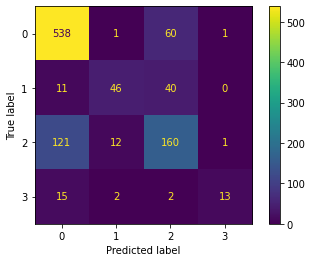

score:  0.739980449657869
[18:42:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


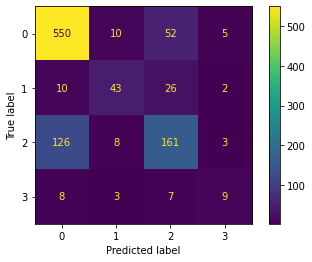

score:  0.7458455522971652


[0.7353515625,
 0.75390625,
 0.7370478983382209,
 0.739980449657869,
 0.7458455522971652]

In [75]:
scores = []
kf = KFold(n_splits=5, shuffle=True)
for train_idx, test_idx in kf.split(X_transformed_train,y=y_dropped):
    x_train = X_transformed_train[train_idx]
    y_train = y_dropped[train_idx]
    x_test = X_transformed_train[test_idx]
    y_test = y_dropped[test_idx]
    xgb_classfier.fit(x_train,y_train)
    y_pred = xgb_classfier.predict(x_test)
    s = f1_score(y_test, y_pred, average='micro')
    plot_confusion_matrix(xgb_classfier,x_test,y_test)
    plt.show()
    print('score: ', s)
    scores.append(s)

scores

[13:41:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:45:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_met

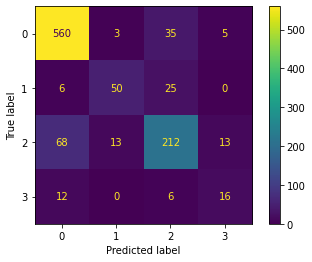

score:  0.818359375
[14:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Exp

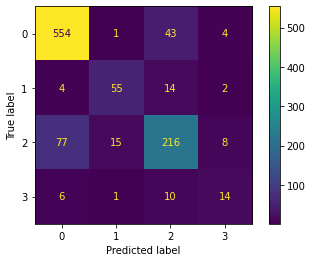

score:  0.8193359375
[15:51:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:54:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Ex

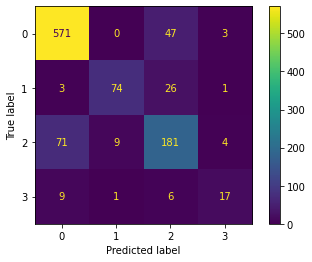

score:  0.8240469208211144
[16:56:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

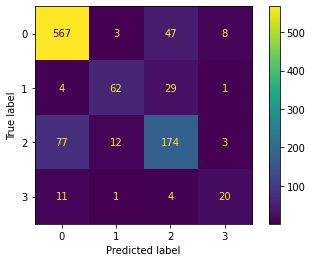

score:  0.8044965786901271
[18:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [18]:
scores = []
kf = KFold(n_splits=5, shuffle=True)
for train_idx, test_idx in kf.split(all_features_train_np,y=y_dropped):
    x_train = all_features_train_np[train_idx]
    y_train = y_dropped[train_idx]
    x_test = all_features_train_np[test_idx]
    y_test = y_dropped[test_idx]
    stacked.fit(x_train,y_train)
    y_pred = stacked.predict(x_test)
    s = f1_score(y_test, y_pred, average='micro')
    plot_confusion_matrix(stacked,x_test,y_test)
    plt.show()
    print('score: ', s)
    scores.append(s)

scores

In [ ]:
sum(scores)/5

0.8178654615713589

In [ ]:
stacked.fit(all_features_train_np,y_dropped)

[02:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:38:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:38:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_met

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              enable_categorical=False,
                                              gamma=None, gpu_id=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None, max_depth=5,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraint...
                                              

In [ ]:
y_prediction_stacked = stacked.predict(all_features_test.to_numpy())

In [ ]:
y_prediction_stacked.shape

(3411,)

In [ ]:
pd.DataFrame(y_prediction_stacked).to_csv('submission_stacking_12_logisticbase.csv')

## Try Autoencoder

In [338]:
from torch import lstm